## Importing Libraries/ Reading our Data

In [1]:
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
XRay_Directory = 'Data'

In [3]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [4]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [5]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [6]:
# Generate a batch of 40 images and labels

train_images, train_labels = next(train_generator)

In [17]:
# 40 images, 256x256 pixes, 3 channels of color
train_images.shape

(40, 256, 256, 3)

In [43]:
train_images

array([[[[0.8117648 , 0.8117648 , 0.8117648 ],
         [0.78823537, 0.78823537, 0.78823537],
         [0.74509805, 0.74509805, 0.74509805],
         ...,
         [0.8431373 , 0.8431373 , 0.8431373 ],
         [0.854902  , 0.854902  , 0.854902  ],
         [0.8705883 , 0.8705883 , 0.8705883 ]],

        [[0.8235295 , 0.8235295 , 0.8235295 ],
         [0.7607844 , 0.7607844 , 0.7607844 ],
         [0.74509805, 0.74509805, 0.74509805],
         ...,
         [0.8352942 , 0.8352942 , 0.8352942 ],
         [0.8431373 , 0.8431373 , 0.8431373 ],
         [0.854902  , 0.854902  , 0.854902  ]],

        [[0.81568635, 0.81568635, 0.81568635],
         [0.81568635, 0.81568635, 0.81568635],
         [0.77647066, 0.77647066, 0.77647066],
         ...,
         [0.85098046, 0.85098046, 0.85098046],
         [0.8862746 , 0.8862746 , 0.8862746 ],
         [0.8588236 , 0.8588236 , 0.8588236 ]],

        ...,

        [[0.12156864, 0.12156864, 0.12156864],
         [0.12156864, 0.12156864, 0.12156864]

In [18]:
# 49 images, each 4 labels
train_labels.shape

(40, 4)

In [20]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]],

In [72]:
from collections import Counter
Counter(np.argmax(train_labels, axis= 1))

Counter({0: 13, 3: 10, 1: 9, 2: 8})

In [35]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## Visualize our Data

In [44]:
# shape of each image 256x 256 x 3
train_images[0].shape

(256, 256, 3)

In [47]:
# labels of each picture
np.argmax(train_labels, axis=1)

array([3, 1, 3, 3, 2, 2, 1, 0, 1, 1, 3, 3, 1, 3, 2, 1, 3, 0, 2, 0, 3, 2,
       1, 2, 2, 0, 1, 2, 3, 1, 2, 3, 1, 3, 3, 2, 1, 2, 2, 3])

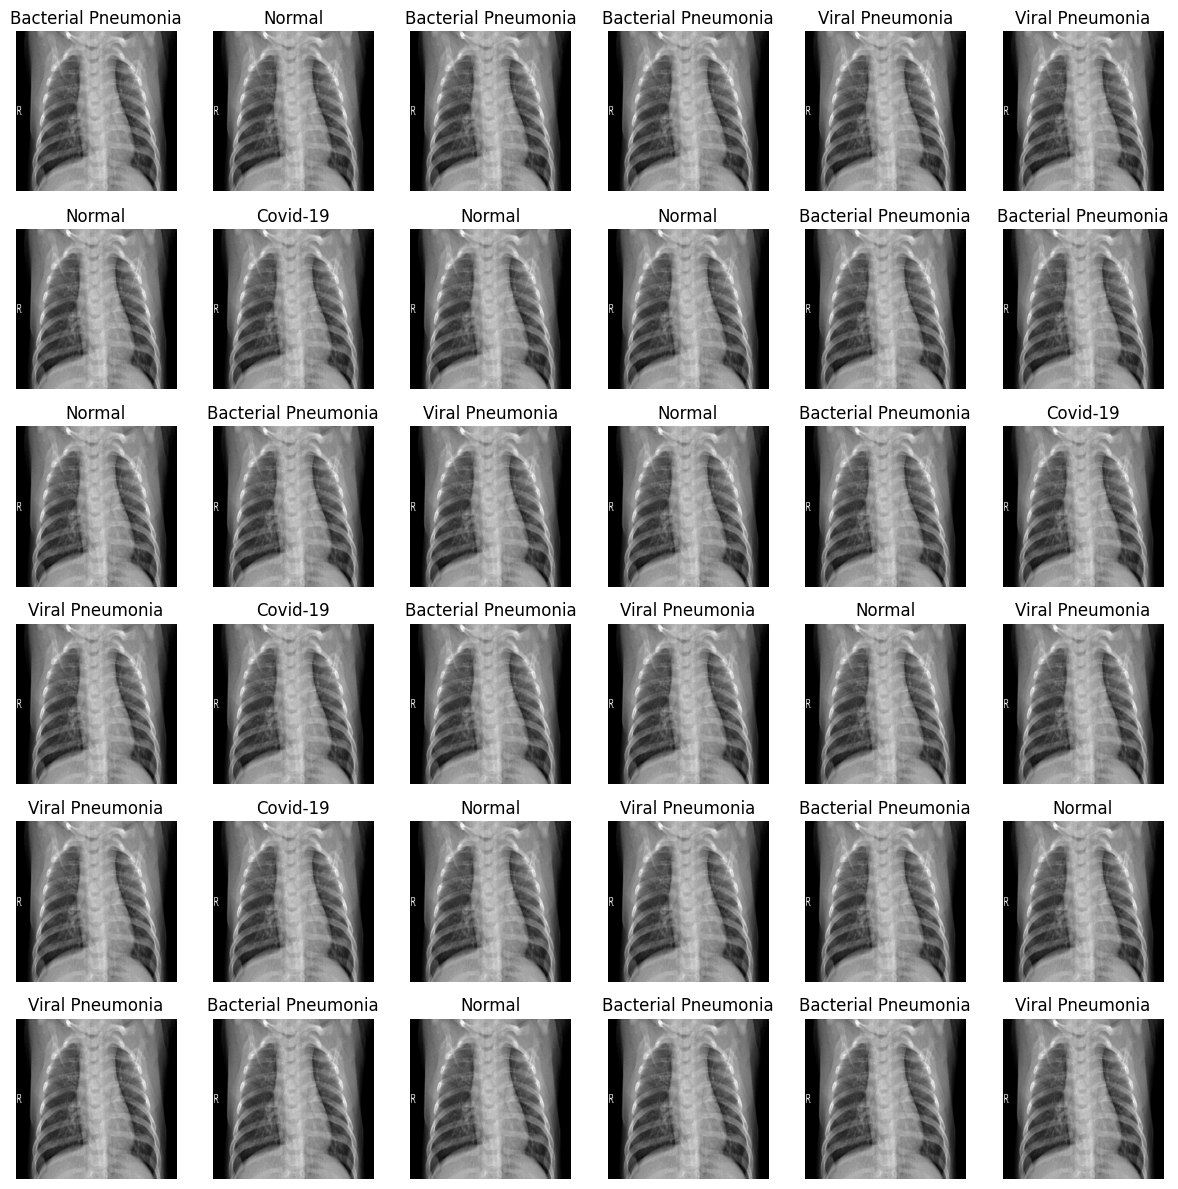

In [52]:
# plotting 36 images

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize= (12, 12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[1])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off') # getting rid of y and x axis to make it more clean
    
plt.tight_layout()


In [54]:
# include_top= False: we dont want to include the top level layer, fully connected layer since it might have different output size, we only have 4 classes
# input_tensor=Input(shape= (256,256,3)): our images are 256x255x3
# weights='imagenet': we want the model that was trained on imagenet dataset that contains millions of images
basemodel = ResNet50(weights='imagenet', include_top= False, input_tensor=Input(shape= (256,256,3)))

94765736/94765736 [==============================] - 357s 4us/step


In [9]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [10]:
# freezing layers in the model
# so we will only be updating the weights of the last 10 layers in the model summary
for layer in basemodel.layers[:-10]:
    layer.trainable = False

## Build and Train our deep learning model

In [11]:
x = basemodel.output
x = AveragePooling2D(pool_size = (4,4))(x)
x = Flatten(name= 'flatten')(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.3)(x) # to avoid overfitting and allow network to generalizing by droping % of random neurons, since neurons can develope codependacy between them
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(4, activation = 'softmax')(x)

model = Model(inputs = basemodel.input, outputs = x)

In [13]:
# normally you do binary_cross_entropy but we have more than 2 classes we can do categorical_cross_entropy
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.legacy.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [14]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
# because we want our model to generalize and not to overfit our training data
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [15]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [16]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/var/folders/2p/cp2l1q2x42l6jgt20fhqkpsw0000gn/T/ipykernel_5720/3164608956.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.7640
Epoch 1: val_loss improved from inf to 0.44424, saving model to weights.hdf5
107/107 [==============================] - 33s 290ms/step - loss: 0.6078 - accuracy: 0.7640 - val_loss: 0.4442 - val_accuracy: 0.8558
Epoch 2/25


/Users/goncalomoura/Documents/Data_science/gcolab/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8598
Epoch 2: val_loss did not improve from 0.44424
107/107 [==============================] - 31s 287ms/step - loss: 0.4212 - accuracy: 0.8598 - val_loss: 0.8559 - val_accuracy: 0.7115
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8621
Epoch 3: val_loss did not improve from 0.44424
107/107 [==============================] - 32s 300ms/step - loss: 0.4093 - accuracy: 0.8621 - val_loss: 0.7872 - val_accuracy: 0.7500
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8832
Epoch 4: val_loss did not improve from 0.44424
107/107 [==============================] - 33s 304ms/step - loss: 0.3197 - accuracy: 0.8832 - val_loss: 0.6531 - val_accuracy: 0.7885
Epoch 5/25
107/107 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8505
Epoch 5: val_loss did not improve from 0.44424
107/107 [============================

## Evaluating Trained Deep Learning Model

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

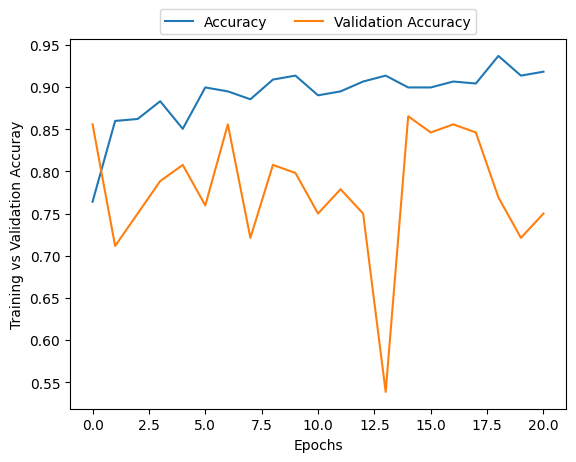

In [18]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training vs Validation Accuray')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()

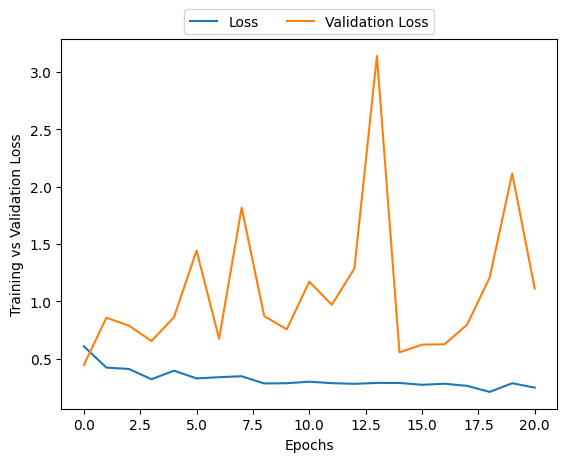

In [19]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Training vs Validation Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()

In [24]:
test_directory = 'Test'
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle=True, target_size= (256, 256), class_mode = 'categorical')
evaluate = model.evaluate(test_generator, steps= test_generator.n//40, verbose= 1)
print(f'Accuracy Test: {evaluate[1]}')

Found 40 images belonging to 4 classes.
1/1 [==============================] - 2s 2s/step - loss: 1.6380 - accuracy: 0.7250
Accuracy Test: 0.7250000238418579


In [73]:
evaluate

[1.6380115747451782, 0.7250000238418579]

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory)) - 1):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 81ms/step


In [32]:
len(original)

40

In [33]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


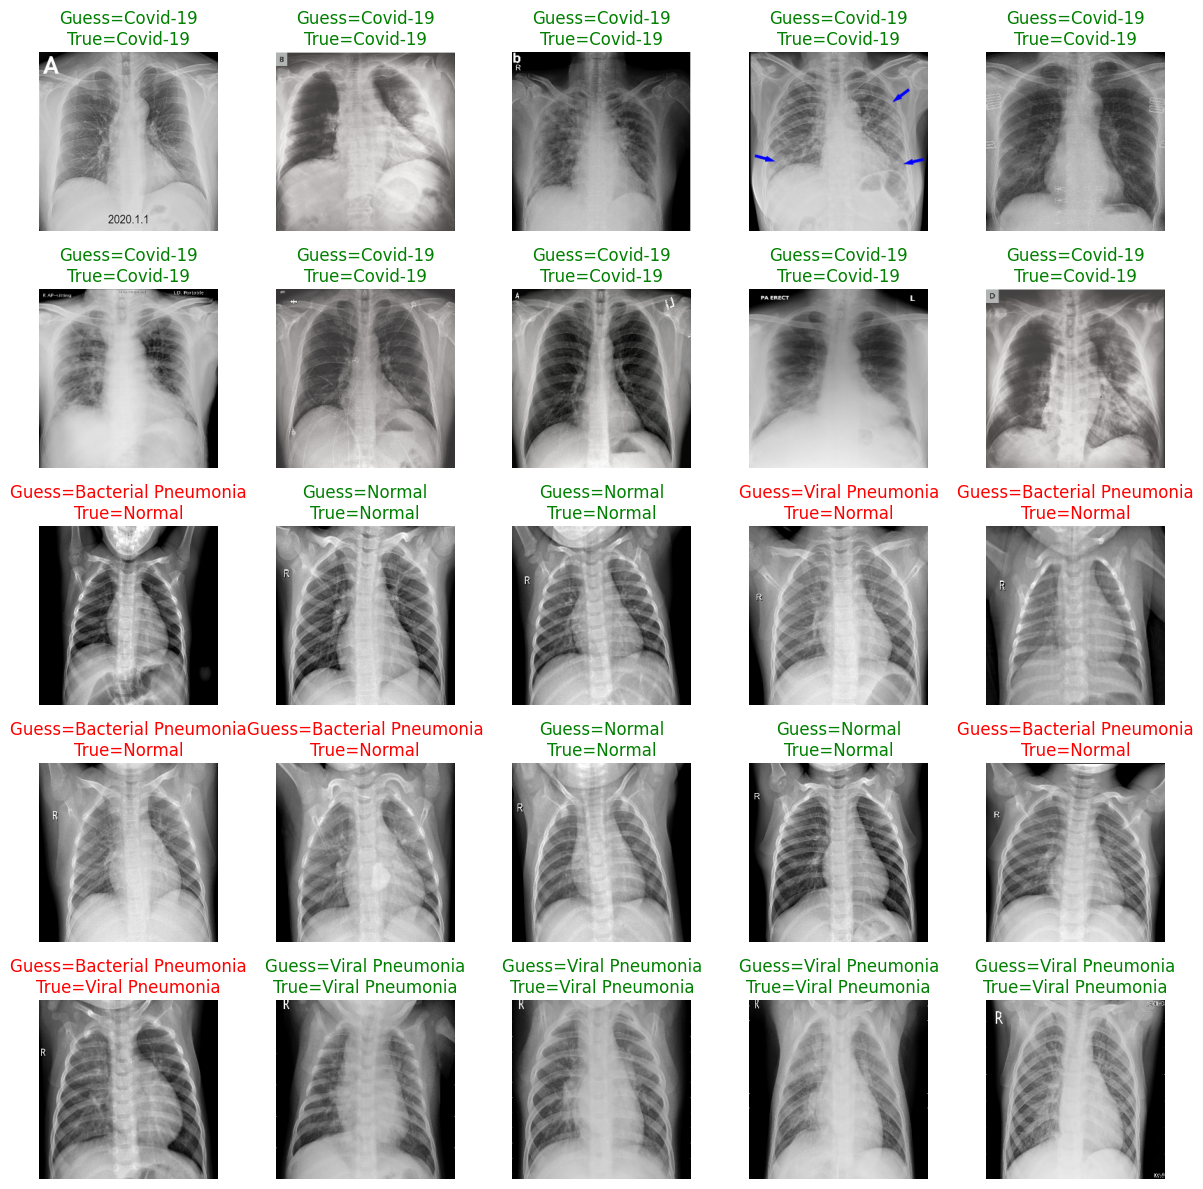

In [46]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(f'Guess={label_names[prediction[i]]}\nTrue={label_names[original[i]]}', color = 'green' if prediction[i] == original[i] else 'red')
    axes[i].axis('off')

plt.tight_layout()

In [47]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.80      0.40      0.53        10
           2       0.83      0.50      0.62        10
           3       0.53      0.90      0.67        10

    accuracy                           0.70        40
   macro avg       0.75      0.70      0.68        40
weighted avg       0.75      0.70      0.68        40



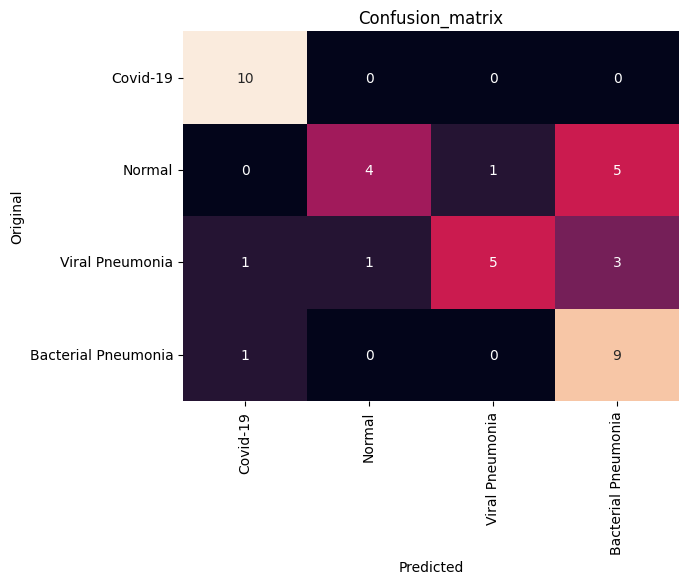

In [66]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}
# as we were able to see from the predicted images we showcased and from this confusion matrix 
# a lot of the time when our model predicts Bacterial Pneumonia it is in reality either normal of Viral Pneumonia

# in order for the model to improve this we could 
# give it more training data
# applying data augmentation techniques to our training data
# using a learning rate scheduler
# fine-tuning more or fewer layers of the base model
# 
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
sns.heatmap(cm, annot = True, cbar= False)

plt.xlabel('Predicted')
plt.xticks([0.5,1.5,2.5,3.5], ['Covid-19', 'Normal' , 'Viral Pneumonia', 'Bacterial Pneumonia'], rotation = 90)
plt.ylabel('Original')
plt.yticks([0.5,1.5,2.5,3.5], ['Covid-19', 'Normal' , 'Viral Pneumonia', 'Bacterial Pneumonia'], rotation = 0)
plt.title('Confusion_matrix')
plt.show()